In [4]:
# Simple GA for TSP

#Imports
import numpy as np
import re
import random
import matplotlib.pyplot as plt

# Get coordinates of the cities from the assignment file.
cities = np.empty((50,2))
with open("file-tsp.txt", mode='r') as f:
  lines = f.readlines()
for l in range(len(lines)):
  coords = lines[l].split()
  cities[l] = [float(i) for i in coords]

# function for euclidean distance between twodimensional city arrays:
def distance(c1, c2):
  # c1: index of first city
  # c2: index of second city

  #Getting city coordinates
  x1 = cities[c1]
  x2 = cities[c2]
  #Calculating distance
  d = np.sqrt(
        np.square(abs(x1[0] - x2[0]))
          + np.square(abs(x1[1] - x2[1]))
        )
  return d

# Evaluation function returning length of TSP configuration for each individual
# in the population.
def calc_fitnesses(population):
  fitnesses = []
  for candidate in population:
    fitness = 0
    position = candidate[0]
    # iterate over all edges
    for city in candidate:
      fitness += distance(position, city)
      position = city 
      # uncomment to force the cycle connect last position to first city
    # fitness += distance(position, candidate[0]) 
    fitnesses.append(fitness)
  fitnesses = np.array(fitnesses)
  return fitnesses

# Function that selects candidates for mating pool. 
def select_candidates(population, fitnesses, M, selection='tournament', t=2):
  # population: current population
  # fitnesses: lengths of TSP configurations of population
  # M: size of mating pool
  # selection: method of selection, either tournament or roulette
  # t: size of tournament for tournament selection

  if selection=='tournament':
    new_population = []
    for i in range(M):
      participants = random.choices(population, k=t)
      outcome = calc_fitnesses(participants)
      new_population.append(participants[np.argmin(outcome)])
  else:
    fitness2 = [abs(f - max(fitnesses)) for f in fitnesses]
    new_population = random.choices(population, weights=fitness2, k=M)
  return new_population 

# Function for recombination of mating pool
def recombine(pool):
  # pool: mating pool

  new_population = []
  # recombine until pool is done
  while len(pool) > 1:
    # select parents
    p1 = pool.pop()
    p2 = pool.pop()
    # define cutpoints
    cut_point1 = np.random.randint(0, len(p1))
    cut_point2 = np.random.randint(0, len(p1))
    if cut_point2 < cut_point1:
      interm = cut_point2
      cut_point2 = cut_point1
      cut_point1 = interm
    cut_len = cut_point2 - cut_point1
    # define children
    c1 = np.empty(50, dtype=int)
    c1.fill(-1)
    c2 = np.empty(50, dtype=int)
    c2.fill(-1)
    for i in range(cut_point1, cut_point2):
      c1[i] = p1[i]
      c2[i] = p2[i]

    # fill children with parents
    for c, p in [(c1, p2), (c2, p1)]:
      index_c = cut_point2
      index_p = cut_point2
      if index_c > 49:
        index_c = 0
      if index_p > 49:
        index_p = 0
      for i in range(50-cut_len):
        while p[index_p] in c:
          index_p +=1
          if index_p > 49:
            index_p = 0
        c[index_c] = p[index_p]
        index_p +=1
        index_c +=1
        if index_c > 49:
          index_c = 0
        if index_p > 49:
          index_p = 0
    new_population.append(c1)
    new_population.append(c2)
  new_population = np.array(new_population)
  return new_population

# Function for random mutations
def mutate(population, p_m):
  # population: population
  # p_m: mutation rate

  for i in range(len(population)):
    if np.random.random() <= p_m:
      p = population[i]
      swap_i = np.random.randint(0, 50)
      swap_j = np.random.randint(0, 50)
      while swap_j == swap_i:
        swap_j = np.random.randint(0, 50)
      interm = p[swap_i]
      p[swap_i] = p[swap_j]
      p[swap_j] = interm
      population[i] = p
  return population

# Function for memetic local search variant
def local_search(population):
  # population: population

  for i in range(len(population)):
    p = population[i]
    cut_point1=1
    cut_point2=1
    distance_1 = 0
    distance_2 = 0
    # find longest edges
    for index in range(len(p)-1):
      new_distance = distance(p[index], p[index+1])
      if new_distance > min(distance_1, distance_2):
        if distance_1 < distance_2:
          distance_1 = new_distance
          cut_point1 = index
        else:
          distance2 = new_distance
          cut_point2 = index
    if cut_point2 < cut_point1:
      inter = cut_point1
      cut_point1 = cut_point2 
      cut_point2 = inter

    # calculate distance for swapping longest edges
    dist_og = distance_1 + distance_2
    dist_new = distance(p[cut_point2], p[cut_point1+1])
    dist_new += distance(p[cut_point1], p[cut_point2+1])

    # if swapping is beneficial, do the swap 
    if dist_new < dist_og:
      p[cut_point1:(cut_point2)] = list(reversed(p[cut_point1:(cut_point2)]))
      population[i] = p
  return population

def doGenetics(N, max_k, p_m, local=False, selection='tournament', t=2):
  # N: size of population
  # max_k: max iter
  # p_m: mutation rate
  # local: use memetic approach using swap
  # selection: what selection approach to use
  #     roulette = our special variant of roulette wheel selection
  #     tournament = binary tournament selection
  #       if tournament, t represents the tournament size

  # iteration counter
  k = 0

  # initialize the population  
  population = np.empty((N, 50), dtype=int)
  for i in range(N):
    population[i] = np.random.permutation(50)


  # apply local search
  if local:
    population = local_search(population)

  # train initial fitness
  fitnesses = calc_fitnesses(population)

  while k < max_k:
    # training loop
    mating_pool = select_candidates(population, fitnesses, N, selection, t=t)

    # create new population through selection, recombination and mutation
    new_population = recombine(mating_pool)
    N = len(new_population) # if first population was odd this is the new even number

    # mutation
    population = mutate(new_population, p_m)

    if local:
      population = local_search(population)
    # train initial fitness
    fitnesses = calc_fitnesses(population)
    min_f = min(fitnesses)
    print(f"ended iteration {k+1}, it has best fitness of {min_f}")
    k+=1

  # find the best solution from the latest population
  best_fitness = min(fitnesses)
  best_solution_i = np.argmin(fitnesses)
  best_solution = population[best_solution_i]
  return best_fitness, best_solution

In [8]:
max_k = 50
best_fitness, best_solution = doGenetics(1000, max_k, 0.01, local=True, selection="tournament", t=5)

ended iteration 1, it has best fitness of 375.1349907154999
ended iteration 2, it has best fitness of 367.38647987407927
ended iteration 3, it has best fitness of 363.7598187942703
ended iteration 4, it has best fitness of 363.7888353975447
ended iteration 5, it has best fitness of 321.10856266037234
ended iteration 6, it has best fitness of 319.72576833464746
ended iteration 7, it has best fitness of 314.13301762852814
ended iteration 8, it has best fitness of 308.5395909444049
ended iteration 9, it has best fitness of 288.7938529431759
ended iteration 10, it has best fitness of 273.03915260419836
ended iteration 11, it has best fitness of 273.03915260419836
ended iteration 12, it has best fitness of 273.03915260419836
ended iteration 13, it has best fitness of 282.2403757763015
ended iteration 14, it has best fitness of 283.6803253814025
ended iteration 15, it has best fitness of 269.018361425643
ended iteration 16, it has best fitness of 250.77818251192184
ended iteration 17, it has

Ideal scenario: running for 150 iterations using the memetic EA algorithm with tournament selection:

Text(0.5, 1.0, 'Best solution after 150 iterations with fitness 129.59640318163957')

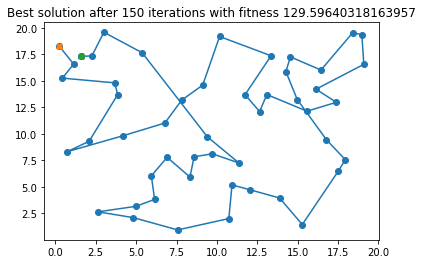

In [ ]:
xs = []
ys = []
for ci in best_solution:
  coords = cities[ci]
  xs.append(coords[0])
  ys.append(coords[1])
plt.plot(xs, ys, '-o')
plt.plot(xs[0], ys[0], 'X')
plt.plot(xs[49], ys[49], 'X')
plt.title(f"Best solution after {max_k} iterations with fitness {best_fitness}".format(max_k, best_fitness))
# ended iteration 30, it has best fitness of 332.3029756792001 N=2000, local = False

50 iterations with the simple EA:

Text(0.5, 1.0, 'Best solution after 50 EA iterations, using 5-tournament selection, with total distance 169.04')

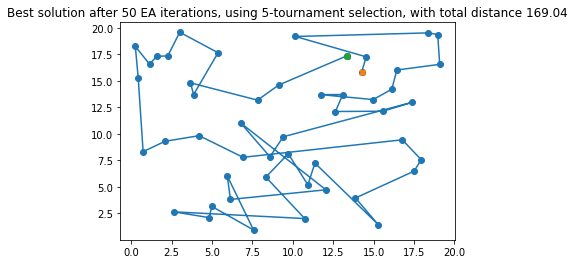

In [ ]:
t = 5
xs = []
ys = []
for ci in best_solution:
  coords = cities[ci]
  xs.append(coords[0])
  ys.append(coords[1])
plt.plot(xs, ys, '-o')
plt.plot(xs[0], ys[0], 'X')
plt.plot(xs[49], ys[49], 'X')
plt.title(f"Best solution after {max_k} EA iterations, using {t}-tournament selection, with total distance {round(best_fitness,2)}")
# ended iteration 30, it has best fitness of 332.3029756792001 N=2000, local = False

50 iterations with the memetic EA:

Text(0.5, 1.0, 'Best solution after 50 memetic EA iterations, using 5-tournament selection, with total distance 155.13')

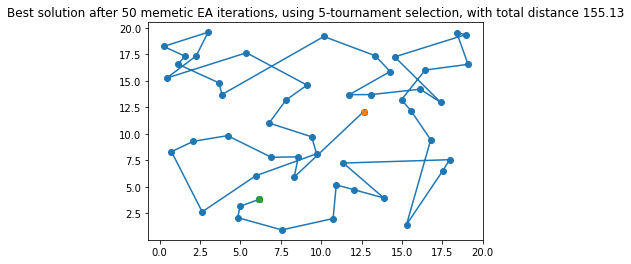

In [ ]:
t = 5
xs = []
ys = []
for ci in best_solution:
  coords = cities[ci]
  xs.append(coords[0])
  ys.append(coords[1])
plt.plot(xs, ys, '-o')
plt.plot(xs[0], ys[0], 'X')
plt.plot(xs[49], ys[49], 'X')
plt.title(f"Best solution after {max_k} memetic EA iterations, using {t}-tournament selection, with total distance {round(best_fitness,2)}")
# ended iteration 30, it has best fitness of 332.3029756792001 N=2000, local = False